In [ ]:
!wget http://www.manythings.org/anki/ita-eng.zip

--2021-01-07 14:29:01--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 172.67.173.198, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7521114 (7.2M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.17M  5.32MB/s    in 1.3s    

2021-01-07 14:29:03 (5.32 MB/s) - ‘ita-eng.zip’ saved [7521114/7521114]



In [ ]:
!unzip ita-eng.zip

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import os
import matplotlib.ticker as ticker
import tensorflow as tf
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM,LSTMCell
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import nltk.translate.bleu_score as bleu
import warnings
warnings.filterwarnings('ignore')


In [ ]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(343813, 2)


,english,italian
0,Hi.,Ciao!
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?


<font color='aqua'>**Preprocess data**</font>

In [ ]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,run,corri
2,run,corra
3,run,correte
4,who,chi


In [ ]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,corri,<start> run,run <end>
2,corra,<start> run,run <end>
3,correte,<start> run,run <end>
4,chi,<start> who,who <end>


In [ ]:
data.sample(5)

,italian,english_inp,english_out
98883,hai sciato ieri,<start> did you ski yesterday,did you ski yesterday <end>
43650,lei è negligente,<start> you are negligent,you are negligent <end>
337369,manderete qualcuno a ripararla il prima possibile,<start> will you send someone to fix it as soo...,will you send someone to fix it as soon as pos...
297648,tom sta affrontando qualche problema serio,<start> tom is facing a few serious problems,tom is facing a few serious problems <end>
299985,avete mai assaggiato una zuppa così buona,<start> have you ever tasted such a good soup,have you ever tasted such a good soup <end>


<font size=5 color = 'cherry'> Getting train and test </font>

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)

In [ ]:
print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(274710, 3) (68678, 3)


In [ ]:
train.head()

,italian,english_inp,english_out
122194,queste sono tue giusto,<start> these are yours right <end>,these are yours right <end> <end>
122984,tom non riesce ad aiutarla adesso,<start> tom can not help you now,tom can not help you now <end>
291305,tom non è disposto a dire la verità,<start> tom is not willing to tell the truth,tom is not willing to tell the truth <end>
234053,ci stai registrando in questo momento,<start> are you recording us right now,are you recording us right now <end>
113667,scegliete tra i due,<start> choose between the two,choose between the two <end>


In [ ]:
validation.head()

,italian,english_inp,english_out
35347,io non riesco a stare in piedi,<start> i can not stand up,i can not stand up <end>
87903,io devo risparmiare denaro,<start> i need to save money,i need to save money <end>
269545,non avere paura non ti farò del male,<start> do not be afraid i will not hurt you,do not be afraid i will not hurt you <end>
262451,io sto provando a non fare arrabbiare tom,<start> i am trying not to make tom angry,i am trying not to make tom angry <end>
118560,voglio sentire chi ha vinto,<start> i want to hear who won,i want to hear who won <end>


<font size =4 color ='pink' > Creating Tokenizer on the train data and learning vocabulary </font>

In [ ]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [ ]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

12825
26223


In [ ]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10170)

### Creating embeddings for english sentences

In [ ]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2021-01-07 14:29:24--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2021-01-07 14:29:24--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf8bd0b9e690e60e1441bda4d2a.dl.dropboxusercontent.com/cd/0/inline/BGi7lODoUc2UVhVKFOLJhTDasCjJpIrMxkmJfOB2JbFLSU2ajHKtqiDF31hUQSoy9B8oT1PAnGbmJmrMTQo5HmhbWhQ7lGwEW7gvvS2uk_pcJ0QPxZVMBZ6fLulvX41U85I/file# [following]
--2021-01-07 14:29:24--  https://ucf8bd0b9e690e60e1441bda4d2a.dl.dropboxusercontent.com/cd/0/inline/BGi7lODoUc2UVhVKFOLJhTDasCjJpIrMxkmJfOB2JbFLSU2ajHKtqiDF31hUQSoy9B8oT1PAnGbmJmrMTQo5HmhbWhQ7lGwE

In [ ]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()



In [ ]:
embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## <font color='gree'>**Implement custom encoder decoder**</font>

<font color='gree'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        self.lstm_output = 0

    def build(self,input_shape):    
        #Initialize Embedding layer
        self.encoder_embedding = Embedding(input_dim = self.inp_vocab_size,output_dim = self.embedding_size,input_length = self.input_length,
                                           mask_zero = True,name = 'Embedding_Layer_Encoder' )
        #Intialize Encoder LSTM layer
        self.lstmcell = tf.keras.layers.LSTMCell(self.lstm_size)
        self.encoder_lstm = RNN(self.lstmcell,return_sequences=True, return_state=True)
        

    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embedding = self.encoder_embedding(input_sequence)
        self.lstm_output,self.lstm_state_h,self.lstm_state_c = self.encoder_lstm(input_embedding)
        return self.lstm_output,self.lstm_state_h,self.lstm_state_c
      
    def initialize_states(self,batch_size):
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        self.lstm_state_h = tf.random.uniform(shape=[batch_size,self.lstm_size],dtype=tf.float32)
        self.lstm_state_c = tf.random.uniform(shape=[batch_size,self.lstm_size],dtype=tf.float32)
        states = [self.lstm_state_h,self.lstm_state_c]
        return states
      

<font color='orange'>**Grader function - 1**</font>

In [ ]:
#my result
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder 
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


In [ ]:
#embedding matrix for grader function
embedding_matrix = np.zeros((13,12))

In [ ]:
class Decoder(tf.keras.Model):
    '''
    Dncoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        #calling Parent class init function
        super().__init__()
        #Intializing parameters
        self.out_vocab_size = out_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length

    def build(self,input_shape):
        #Initialize Embedding layer
        self.decoder_embed = Embedding(input_dim = self.out_vocab_size,output_dim = self.embedding_size,input_length = self.input_length,
                                       mask_zero = True,name = "Embedding_layer_Decoder",weights = [embedding_matrix],trainable = False)
        #Intialize Decoder LSTM layer
        self.lstmcell = tf.keras.layers.LSTMCell(self.lstm_size)
        self.decoder_lstm = RNN(self.lstmcell,return_sequences=True, return_state=True)


    def call(self,input_sequence_decoder,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        target_embedd           = self.decoder_embed(input_sequence_decoder)
        decoder_output, decoder_final_state_h,decoder_final_state_c  = self.decoder_lstm(target_embedd, initial_state=[initial_states[0], initial_states[1]])
        return decoder_output,decoder_final_state_h,decoder_final_state_c

      


<font color='orange'>**Grader function - 2**</font>

In [ ]:
#my result
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
        
    
    '''
    out_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())


True


<font size  = 5  color = 'violet'> Creating data pipeline </font>

In [ ]:
class dataset:
    def __init__(self,data,tknizer_ita,tknizer_eng,max_len):

        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self,i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])


        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)  


class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)          


In [ ]:
train_dataset = dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = dataset(validation, tknizer_ita, tknizer_eng, 20)


train_dataloader = Dataloder(train_dataset, batch_size=1024)
test_dataloader = Dataloder(test_dataset, batch_size=1024)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)


<font size =6 color = 'DarkOrange'><b>MODEL-1</b></font>

In [ ]:
class Encoder_Decoder(tf.keras.Model):
    
    def __init__(self,encoder_inputs_length,decoder_inputs_length, output_vocab_size):
        
        super().__init__() 
        #create encoder object
        self.encoder = Encoder(inp_vocab_size=vocab_size_ita+1, embedding_size=100, input_length=encoder_inputs_length, lstm_size=256)
        #create decoder object   out_vocab_size,embedding_size,lstm_size,input_length
        self.decoder = Decoder(out_vocab_size=vocab_size_eng+1, embedding_size=100, input_length=decoder_inputs_length, lstm_size=256)
        #output dense layer
        self.dense   = Dense(output_vocab_size, activation='softmax')
    
    
    def call(self,data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        input,output = data[0], data[1]
        batch_size = 1024
        states = self.encoder.initialize_states(batch_size)
        encoder_output, encoder_h, encoder_c = self.encoder(input,states)
        encoder_states = [encoder_h, encoder_c]
        decoder_output,decoder_h,decoder_c   = self.decoder(output, encoder_states)
        output                               = self.dense(decoder_output)
        return output
        
        

In [ ]:
%%time
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model
model  = Encoder_Decoder(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy')
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=50, validation_data=test_dataloader, validation_steps=valid_steps)
model.summary()

Epoch 1/50
268/268 [==============================] - 104s 377ms/step - loss: 2.0807 - val_loss: 1.5731
Epoch 2/50
268/268 [==============================] - 101s 375ms/step - loss: 1.5248 - val_loss: 1.3814
Epoch 3/50
268/268 [==============================] - 103s 385ms/step - loss: 1.3386 - val_loss: 1.2129
Epoch 4/50
268/268 [==============================] - 104s 389ms/step - loss: 1.1773 - val_loss: 1.0871
Epoch 5/50
268/268 [==============================] - 103s 385ms/step - loss: 1.0534 - val_loss: 0.9821
Epoch 6/50
268/268 [==============================] - 103s 386ms/step - loss: 0.9456 - val_loss: 0.8896
Epoch 7/50
268/268 [==============================] - 104s 390ms/step - loss: 0.8496 - val_loss: 0.8080
Epoch 8/50
268/268 [==============================] - 105s 391ms/step - loss: 0.7652 - val_loss: 0.7332
Epoch 9/50
268/268 [==============================] - 104s 388ms/step - loss: 0.6845 - val_loss: 0.6666
Epoch 10/50
268/268 [==============================] - 104s 388m

In [ ]:
prediction_data = validation.sample(1000)
prediction_data.head()

,italian,english_inp,english_out
197862,lasciate che vi prepari un po di caffè,<start> let me make you some coffee,let me make you some coffee <end>
1517,pagai anticipatamente,<start> i prepaid,i prepaid <end>
181046,sono sicuro che piacerete a tom,<start> i am sure tom will like you,i am sure tom will like you <end>
266421,tom ha accompagnato mary nel suo ufficio,<start> tom ushered mary into his office,tom ushered mary into his office <end>
65309,tom è ancora vivo,<start> tom is still alive,tom is still alive <end>


In [ ]:
prediction_data_inps = prediction_data['italian'].values


In [ ]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predicted_out,state_h,state_c=model.layers[1](dec_input,states)
         pass the predicted_out to the dense layer
         update the states=[state_h,state_c]
         And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
         Update the input_to_decoder with current predictions
  F. Return the predicted sentence
  '''
  sentence  = []
  
  #preprocessing input sentence
  input_sentence = input_sentence.split()
  input_seq = tknizer_ita.texts_to_sequences([input_sentence])
  
  input_seq = pad_sequences(input_seq, maxlen=20, dtype='int32', padding='post')
  
  #input the preprocessed sentence to encoder 
  batch_size = 1
  states = model.layers[0].initialize_states(batch_size)
  encoder_out,encoder_h,encoder_c = model.layers[0](input_seq,states)
  states = [encoder_h,encoder_c]

  #initial input to the decorder
  sos_inp = tknizer_eng.texts_to_sequences([['<start>']])
  curr_vec = pad_sequences(sos_inp,maxlen=20,dtype='int32', padding='post')
  
  #predicting the english words
  for i in range(20):
      try:
        curr_embed = model.layers[1].decoder_embed(curr_vec)
        [infe_output, state_h, state_c] = model.layers[1].decoder_lstm(curr_embed,states)
        infe_output = model.layers[2](infe_output)    
        states = [state_h, state_c]
        curr_vec = np.reshape(np.argmax(infe_output), (1, 1))
        index = np.argmax(infe_output)
        if tknizer_eng.index_word[index] == '<end>':
            break
        else:    
            word = tknizer_eng.index_word[index]
            sentence.append(word)
      except:
          continue    
      

  return sentence

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
prediction_data_inps = prediction_data['italian'].values
prediction_sent_list = []
for input_sentence in prediction_data_inps:
    prediction_sent_list.append(predict(input_sentence))

In [ ]:
prediction_sent_list[:5]

[[],
 ['i', 'prepaid'],
 ['i', 'am', 'sure', 'tom', 'will', 'like', 'you'],
 [],
 []]

In [ ]:
prediction_eng_inps = prediction_data['english_inp'].values

In [ ]:
prediction_eng_inps[:5]

array(['<start> let me make you some coffee', '<start> i prepaid',
       '<start> i am sure tom will like you',
       '<start> tom ushered mary into his office',
       '<start> tom is still alive'], dtype=object)

In [ ]:
eng_inps = []
for i in prediction_eng_inps:
    sent = []
    for j in i.split():
        if j!= '<start>':
            sent.append(j)
    eng_inps.append(sent)
    
eng_inps[:5]

[['let', 'me', 'make', 'you', 'some', 'coffee'],
 ['i', 'prepaid'],
 ['i', 'am', 'sure', 'tom', 'will', 'like', 'you'],
 ['tom', 'ushered', 'mary', 'into', 'his', 'office'],
 ['tom', 'is', 'still', 'alive']]

In [ ]:
import nltk.translate.bleu_score as bleu
blue_score = []
for i in range(len(prediction_sent_list)):
    blue_score.append(bleu.sentence_bleu([eng_inps[i]], prediction_sent_list[i]))

In [ ]:
#Average Blue Score
print('avg_blue_score ',(sum(blue_score)/len(blue_score)))

avg_blue_score  0.5858630324148351


## Task -2: Including Attention mechanisum

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM,LSTMCell
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import nltk.translate.bleu_score as bleu
import warnings
warnings.filterwarnings('ignore')

### <font color='yellow'>**Implement custom encoder decoder and attention layers**</font>

<font color='gree'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        #intializing parameters
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        self.lstm_output = 0

        #Initialize Embedding layer
        self.encoder_embedding = Embedding(input_dim = self.inp_vocab_size,output_dim = self.embedding_size,input_length = self.input_length,
                                           mask_zero = True,name = 'Embedding_Layer_Encoder' )
        #Intialize Encoder LSTM layer
        self.lstmcell = tf.keras.layers.LSTMCell(self.lstm_size)
        self.encoder_lstm = RNN(self.lstmcell,return_sequences=True, return_state=True)

    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
        '''
        input_embedding = self.encoder_embedding(input_sequence)
        self.lstm_output,self.lstm_state_h,self.lstm_state_c = self.encoder_lstm(input_embedding)
        return self.lstm_output,self.lstm_state_h,self.lstm_state_c
    
    def initialize_states(self,batch_size):
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        self.lstm_state_h = tf.random.uniform(shape=[batch_size,self.lstm_size],dtype=tf.float32)
        self.lstm_state_c = tf.random.uniform(shape=[batch_size,self.lstm_size],dtype=tf.float32)
        states = [self.lstm_state_h,self.lstm_state_c]
        return states


<font color='cyan'>**Grader function - 1**</font>

In [ ]:
#my results
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


<font color='DarkTurquoise'>**Attention**</font>

In [ ]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_fun, att_units):
    super().__init__()
    self.scoring_fun = scoring_fun
    self.att_units = att_units

    if self.scoring_fun=='dot':
      # Intialize variables needed for Dot score function here
      pass
    if self.scoring_fun == 'general':
      # Intialize variables needed for General score function here
      self.weight_mtx = Dense(self.att_units)
      
    elif self.scoring_fun == 'concat':
      # Intialize variables needed for Concat score function here
      self.weight_mtx1 = Dense(self.att_units)
      self.weight_mtx2 = Dense(self.att_units)
      self.vec = Dense(1)
      pass
  
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    
    if self.scoring_fun == 'dot':
        # Implement Dot score function here
        #for dot layer number of hidden units are same
        hidden_state = tf.expand_dims(decoder_hidden_state,1)
        
        score = tf.keras.layers.Dot(axes=(2,2))([encoder_output,hidden_state])   #(batch_size,1,hidden_units_d)*(batch_size,input_length,hidden_unit_e)
        
        attention_weights = tf.nn.softmax(score,axis = 1)
        #print('attention_weights shape',attention_weights.shape)
        context_vector = tf.keras.layers.Dot(axes=(1,1))([attention_weights,encoder_output])

        context_vector =tf.reduce_sum(context_vector,axis = 1)
        #print('context vector shape',context_vector.shape)
        return context_vector,attention_weights

    elif self.scoring_fun == 'general':
        # Implement General score function here
        #print('shape of weight mtx',self.weight_mtx.output_shape)
        hidden_state = tf.expand_dims(decoder_hidden_state,1)
        #print('shape of encoder output',encoder_output.shape)
        score = self.weight_mtx(encoder_output)
        #print('score shape after first multiplication',score.shape)
        score = tf.keras.layers.Dot(axes = (2,2))([score,hidden_state])
        #print('score shape after second multiplication',score.shape)
        attention_weights = tf.nn.softmax(score,axis = 1)
        #print('attention_weights shape general',attention_weights.shape)
        context_vector = attention_weights*encoder_output

        context_vector =tf.reduce_sum(context_vector,axis = 1)
        #print('context_vector shape general',context_vector.shape)
        return context_vector,attention_weights
    elif self.scoring_fun == 'concat':
        # Implement General score function here
        hidden_state = tf.expand_dims(decoder_hidden_state,1)
 
        score = self.vec(tf.nn.tanh(self.weight_mtx1(encoder_output)+ self.weight_mtx2(hidden_state)))

        attention_weights = tf.nn.softmax(score,axis = 1)
        #print('attention_weights shape concat',attention_weights.shape)
        context_vector = attention_weights*encoder_output

        context_vector =tf.reduce_sum(context_vector,axis = 1)
        #print('context_vector shape concat',context_vector.shape)
        return context_vector,attention_weights
    
    

<font color='cyan'>**Grader function - 2**</font>

In [ ]:
#my results
def grader_check_attention(scoring_fun):
    
    ''' 
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


<font color='DodgerBlue'>**OneStepDecoder**</font>

In [ ]:
class OneStepDecoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):

    # Initialize decoder embedding layer, LSTM and any other objects needed
    super().__init__()  
    self.tar_vocab_size = tar_vocab_size
    self.embedding_dim = embedding_dim
    self.input_length = input_length
    self.dec_units = dec_units
    self.score_fun = score_fun
    self.att_units = att_units
    self.attention = Attention(self.score_fun,self.att_units)
    self.decoder_embedding = Embedding(input_dim=self.tar_vocab_size,output_dim=self.embedding_dim,input_length=self.input_length)
    self.lstmcell = tf.keras.layers.LSTMCell(self.dec_units)
    self.OSD_lstm = RNN(self.lstmcell,return_sequences=True, return_state=True)
    self.OSD_Dense = Dense(self.tar_vocab_size)
    



  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    input_to_decoder = self.decoder_embedding(input_to_decoder)
    #print('input_to_decoder shape',input_to_decoder.shape)
    #print('state_h shape',state_h.shape)
    #print('state_c shape',state_c.shape)
    #print('encoder_output shape',encoder_output.shape)
    
    context_vector,attention_weights = self.attention(state_h,encoder_output)
    #print('context vector shape',context_vector.shape)
    #print('input to decorder shaper before concat',input_to_decoder.shape)
    concat = tf.concat([tf.expand_dims(context_vector,1),input_to_decoder],axis=-1)
    #print('concat shape',concat.shape)
    decoder_output,state_h,state_c = self.OSD_lstm(concat,[state_h,state_c])
    decoder_output = tf.reshape(decoder_output,shape=(-1,decoder_output.shape[2]))
    output = self.OSD_Dense(decoder_output)
    #output = tf.reshape(output,shape=(-1,output.shape[2]))
    #print('output shape',output.shape)
    return output,state_h,state_c,attention_weights





<font color='cyan'>**Grader function - 3**</font>

In [ ]:
#my result
def grader_onestepdecoder(score_fun):
    
    '''
        tar_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    tar_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=OneStepDecoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))

True
True
True


<font color='DeepPink'>**Decoder**</font>

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super(Decoder,self).__init__()
      self.out_vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.score_fun = score_fun
      self.att_units = att_units
      self.onestepdecoder = OneStepDecoder(self.out_vocab_size,self.embedding_dim,self.input_length,self.dec_units,self.score_fun,self.att_units)

        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        all_outputs = tf.TensorArray(tf.float32,size = 20,name = 'Output_Arrays')
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
        for timesteps in range(20):

            output,decoder_hidden_state,decoder_cell_state,attention_weights = self.onestepdecoder(input_to_decoder[:,timesteps:timesteps+1],encoder_output,decoder_hidden_state,decoder_cell_state)
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
            all_outputs = all_outputs.write(timesteps,output)
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])    
        # Return the tensor array
        return all_outputs
        
        
    

<font color='cyan'>**Grader function - 4**</font>

In [ ]:
#my result
def grader_decoder(score_fun):
    
    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    out_vocab_size=13 
    embedding_dim=12 
    input_length=11
    dec_units=16 
    att_units=16
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


# <font color='Red'>**Model-2**</font>

<font color='MediumSpringGreen'>**Encoder Decoder model**</font>

In [ ]:
class Encoder_Decoder(tf.keras.Model):
  def __init__(self,encoder_inputs_length,decoder_inputs_length, output_vocab_size):
    #Intialize objects from encoder decoder
    super().__init__() 
    #create encoder object
    self.encoder = Encoder(inp_vocab_size=vocab_size_ita+1, embedding_size=200, input_length=encoder_inputs_length, lstm_size=256)
    #create decoder object
    self.decoder = Decoder(out_vocab_size=vocab_size_eng+1, embedding_dim=200, input_length=decoder_inputs_length,dec_units = 256,score_fun = 'dot',att_units=256)
  
  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    input,output = data[0], data[1]
    batch_size = 1024
    states                               = self.encoder.initialize_states(batch_size)
    encoder_output, encoder_h, encoder_c = self.encoder(input,states)
    encoder_states                       = [encoder_h, encoder_c]
    decoder_hidden_state                 = encoder_h
    decoder_cell_state                   = encoder_c
    decoder_output                       = self.decoder(output, encoder_output,decoder_hidden_state,decoder_cell_state)
    return decoder_output



<font color='Moccasin'>**Custom loss function**</font>

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def custom_lossfunction(targets,logits):
  # Custom loss function that will not consider the loss for padded zeros.
  mask = tf.math.logical_not(tf.math.equal(targets, 0))
  loss_ = loss_object(targets, logits)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)



## <font color='Teal'>**Training Dot Function**</font>

In [ ]:
checkpoint_path = "Attention_dot_model/w1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [ ]:
%%time
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model
model  = Encoder_Decoder(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng)
model.compile(optimizer=optimizer,loss=custom_lossfunction)
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=40, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[cp_callback])
model.summary()

Epoch 1/40
268/268 [==============================] - 149s 479ms/step - loss: 2.1207 - val_loss: 1.6204

Epoch 00001: saving model to Attention_dot_model/w1.ckpt
Epoch 2/40
268/268 [==============================] - 128s 478ms/step - loss: 1.5843 - val_loss: 1.4063

Epoch 00002: saving model to Attention_dot_model/w1.ckpt
Epoch 3/40
268/268 [==============================] - 128s 479ms/step - loss: 1.3462 - val_loss: 1.1697

Epoch 00003: saving model to Attention_dot_model/w1.ckpt
Epoch 4/40
268/268 [==============================] - 130s 486ms/step - loss: 1.1172 - val_loss: 0.9914

Epoch 00004: saving model to Attention_dot_model/w1.ckpt
Epoch 5/40
268/268 [==============================] - 130s 485ms/step - loss: 0.9388 - val_loss: 0.8326

Epoch 00005: saving model to Attention_dot_model/w1.ckpt
Epoch 6/40
268/268 [==============================] - 132s 492ms/step - loss: 0.7791 - val_loss: 0.7050

Epoch 00006: saving model to Attention_dot_model/w1.ckpt
Epoch 7/40
268/268 [========

## <font color='Turquoise'>**Inference**</font>

<font color='Tomato'>**Plot attention weights**</font>

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


<font color='PowderBlue'>**Predict the sentence translation**</font>

In [ ]:
#predict for attention
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  print('input_sentence',input_sentence)
  result = []
  
  #preprocessing input sentence
  input_sentence = input_sentence.split()
  input_seq = tknizer_ita.texts_to_sequences([input_sentence])
  
  input_seq = pad_sequences(input_seq, maxlen=20, dtype='int32', padding='post')
  
  #input the preprocessed sentence to encoder 
  batch_size = 1
  states = model.layers[0].initialize_states(batch_size)
  encoder_out,encoder_h,encoder_c = model.layers[0](input_seq,states)
  states = [encoder_h,encoder_c]

  #initial input to the decorder
  dec_inp = tf.expand_dims([tknizer_eng.word_index['<start>']], 0)

  #initialize decoder hidden state
  dec_h = encoder_h
  dec_c = encoder_c
  att_wts = []

  for i in range(20):
      #print('1')  
      predictions, dec_h, dec_c, attention_weights = model.layers[1].onestepdecoder(dec_inp, encoder_out, dec_h,dec_c)

      attention_weights = tf.reshape(attention_weights, (-1, ))
      att_wts.append(attention_weights)
        
      prediction_id =  tf.argmax(predictions[0]).numpy()
      prediction_id = np.argmax(predictions)

      if tknizer_eng.index_word[prediction_id] == '<end>':
          break 
      else:
          result.append(tknizer_eng.index_word[prediction_id]) 
          
      dec_inp = tf.expand_dims([prediction_id], 0)    
    
   
         
  plot_attention(att_wts,input_sentence,result)      
  return result   

In [ ]:
prediction_data = validation.sample(10)
prediction_data.head()

,italian,english_inp,english_out
286878,hai finito di leggere il romanzo,<start> have you finished reading the novel,have you finished reading the novel <end>
136221,ovviamente non è vera,<start> of course it is not true,of course it is not true <end>
153404,loro avevano idee diverse,<start> they had different ideas,they had different ideas <end>
85760,gli piace questa chitarra,<start> he likes this guitar,he likes this guitar <end>
33079,quelle sono per me,<start> are those for me,are those for me <end>


In [ ]:
prediction_data_inps = prediction_data['italian'].values

input_sentence hai finito di leggere il romanzo


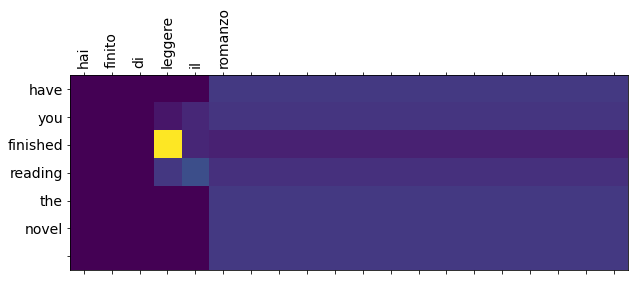

input_sentence ovviamente non è vera


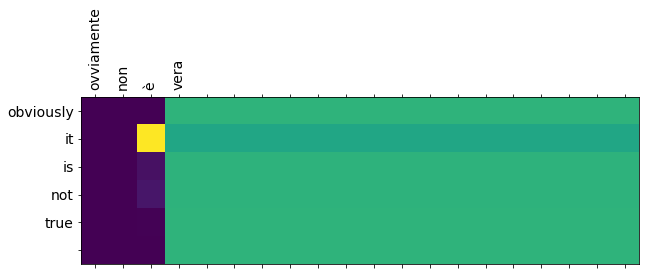

input_sentence loro avevano idee diverse


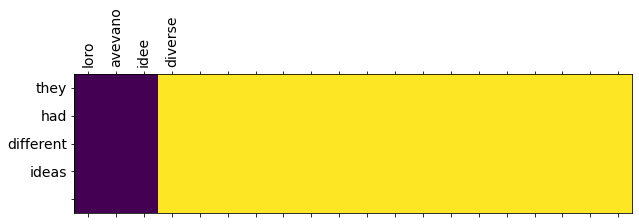

input_sentence gli piace questa chitarra


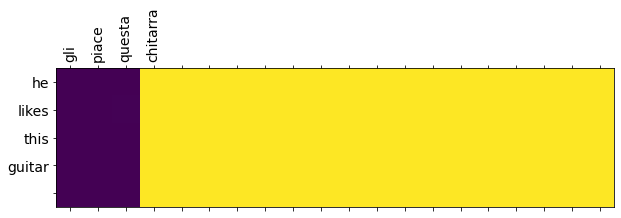

input_sentence quelle sono per me


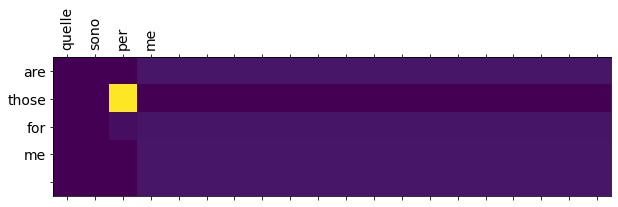

input_sentence tom è innamorato di me


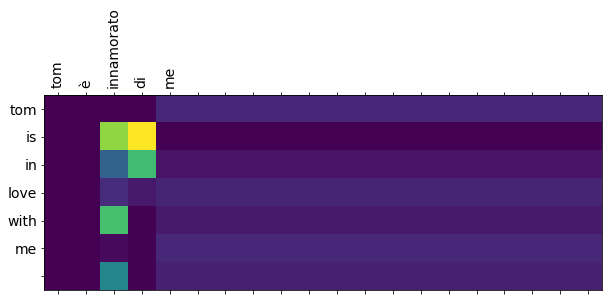

input_sentence tu sei malvagia


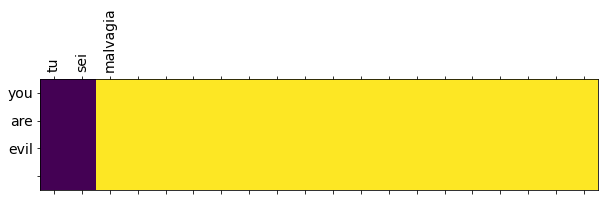

input_sentence il tumulto è sfuggito di mano


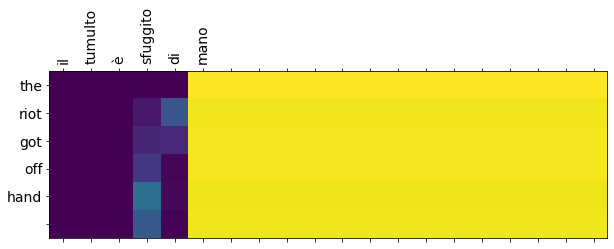

input_sentence tom e mary sono una bella coppia


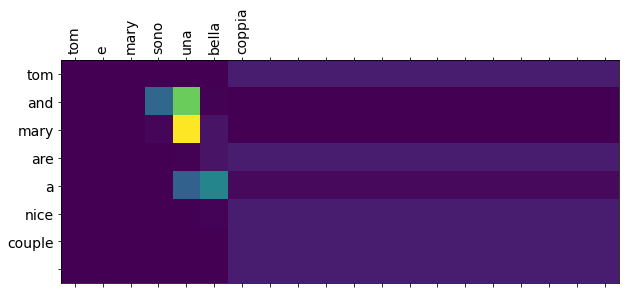

input_sentence che cane strano


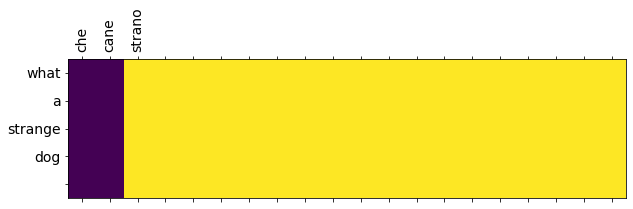

In [ ]:
predicted_sent = []
for input_sentence in prediction_data_inps:
    predicted_sent.append(predict(input_sentence))

In [ ]:
predicted_sent

[['have', 'you', 'finished', 'reading', 'the', 'novel'],
 ['obviously', 'it', 'is', 'not', 'true'],
 ['they', 'had', 'different', 'ideas'],
 ['he', 'likes', 'this', 'guitar'],
 ['are', 'those', 'for', 'me'],
 ['tom', 'is', 'in', 'love', 'with', 'me'],
 ['you', 'are', 'evil'],
 ['the', 'riot', 'got', 'off', 'hand'],
 ['tom', 'and', 'mary', 'are', 'a', 'nice', 'couple'],
 ['what', 'a', 'strange', 'dog']]

<font color='PowderBlue'>**Calculate BLEU score**</font>

In [ ]:
prediction_data = validation.sample(1000)
prediction_data.head()

,italian,english_inp,english_out
8690,io ho diciottanni,<start> i am eighteen,i am eighteen <end>
116638,non bevo e non fumo,<start> i do not drink or smoke,i do not drink or smoke <end>
244900,lei dovera tre anni fa,<start> where were you three years ago,where were you three years ago <end>
264384,loro sono lottatori di sumo giapponesi,<start> they are japanese sumo wrestlers,they are japanese sumo wrestlers <end>
331850,perché non smette di preoccuparsi e dorme un po,<start> why do not you stop worrying and get s...,why do not you stop worrying and get some slee...


In [ ]:
#predict for attention
def predict2(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''
  #print('input_sentence',input_sentence)
  result = []
  
  #preprocessing input sentence
  input_sentence = input_sentence.split()
  input_seq = tknizer_ita.texts_to_sequences([input_sentence])
  
  input_seq = pad_sequences(input_seq, maxlen=20, dtype='int32', padding='post')
  
  #input the preprocessed sentence to encoder 
  batch_size = 1
  states = model.layers[0].initialize_states(batch_size)
  encoder_out,encoder_h,encoder_c = model.layers[0](input_seq,states)
  states = [encoder_h,encoder_c]
  #initial input to the decorder
  dec_inp = tf.expand_dims([tknizer_eng.word_index['<start>']], 0)

  dec_h = encoder_h
  dec_c = encoder_c
  att_wts = []

  for i in range(20):
      #print('1')  
      predictions, dec_h, dec_c, attention_weights = model.layers[1].onestepdecoder(dec_inp, encoder_out, dec_h,dec_c)

      attention_weights = tf.reshape(attention_weights, (-1, ))
      att_wts.append(attention_weights)
        
      prediction_id =  tf.argmax(predictions[0]).numpy()
      prediction_id = np.argmax(predictions)
      if tknizer_eng.index_word[prediction_id] == '<end>':
          break 
      else:
          result.append(tknizer_eng.index_word[prediction_id])


      dec_inp = tf.expand_dims([prediction_id], 0)       
    
  return result   

In [ ]:
prediction_data_inps = prediction_data['italian'].values

In [ ]:
predicted_sent = []
for input_sentence in prediction_data_inps:
    predicted_sent.append(predict2(input_sentence))

In [ ]:
predicted_sent[:5]

[['i', 'am', '18'],
 ['i', 'neither', 'drink', 'nor', 'smoke'],
 ['where', 'were', 'you', 'three', 'years', 'ago'],
 ['they', 'are', 'japanese', 'sumo', 'wrestlers'],
 ['why', 'do', 'you', 'not', 'touch', 'me', 'talking', 'while']]

In [ ]:
prediction_eng_inps = prediction_data['english_inp'].values


In [ ]:
eng_inps = []
for i in prediction_eng_inps:
    sent = []
    for j in i.split():
        if j!= '<start>':
            sent.append(j)
    eng_inps.append(sent)

eng_inps[:5]

[['i', 'am', 'eighteen'],
 ['i', 'do', 'not', 'drink', 'or', 'smoke'],
 ['where', 'were', 'you', 'three', 'years', 'ago'],
 ['they', 'are', 'japanese', 'sumo', 'wrestlers'],
 ['why',
  'do',
  'not',
  'you',
  'stop',
  'worrying',
  'and',
  'get',
  'some',
  'sleep']]

In [ ]:
import nltk.translate.bleu_score as bleu
blue_score = []
for i in range(len(predicted_sent)):
    blue_score.append(bleu.sentence_bleu([eng_inps[i]], predicted_sent[i]))

In [ ]:
blue_score[:5]

[0.7598356856515925, 0.7205745450576256, 1.0, 1.0, 0.4026190971287384]

In [ ]:
#Average Blue Score
print('avg_blue_score ',(sum(blue_score)/len(blue_score)))

avg_blue_score  0.840283581319609


# <font color='Red'>**Model-3 General Scoring**</font>

In [ ]:
class Encoder_Decoder(tf.keras.Model):
  def __init__(self,encoder_inputs_length,decoder_inputs_length, output_vocab_size):
    #Intialize objects from encoder decoder
    super().__init__() 
    #create encoder object
    self.encoder = Encoder(inp_vocab_size=vocab_size_ita+1, embedding_size=200, input_length=encoder_inputs_length, lstm_size=256)
    #create decoder object
    self.decoder = Decoder(out_vocab_size=vocab_size_eng+1, embedding_dim=200, input_length=decoder_inputs_length,dec_units = 256,score_fun = 'general',att_units=256)

    #output dense layer
    #self.dense   = Dense(output_vocab_size, activation='softmax')
  
  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    input,output = data[0], data[1]
    batch_size = 1024
    states                               = self.encoder.initialize_states(batch_size)
    encoder_output, encoder_h, encoder_c = self.encoder(input,states)
    encoder_states                       = [encoder_h, encoder_c]
    decoder_hidden_state                 = encoder_h
    decoder_cell_state                   = encoder_c
    decoder_output                       = self.decoder(output, encoder_output,decoder_hidden_state,decoder_cell_state)
    return decoder_output

In [ ]:
checkpoint_path = "Attention_general_model/w1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [ ]:
%%time
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model
model  = Encoder_Decoder(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng)
model.compile(optimizer=optimizer,loss=custom_lossfunction)
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=30, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[cp_callback])
model.summary()

Epoch 1/30
268/268 [==============================] - 172s 564ms/step - loss: 1.9016 - val_loss: 1.4885

Epoch 00001: saving model to Attention_general_model/w1.ckpt
Epoch 2/30
268/268 [==============================] - 147s 547ms/step - loss: 1.4447 - val_loss: 1.3084

Epoch 00002: saving model to Attention_general_model/w1.ckpt
Epoch 3/30
268/268 [==============================] - 146s 547ms/step - loss: 1.2615 - val_loss: 1.1489

Epoch 00003: saving model to Attention_general_model/w1.ckpt
Epoch 4/30
268/268 [==============================] - 146s 543ms/step - loss: 1.1022 - val_loss: 1.0119

Epoch 00004: saving model to Attention_general_model/w1.ckpt
Epoch 5/30
268/268 [==============================] - 147s 547ms/step - loss: 0.9656 - val_loss: 0.8949

Epoch 00005: saving model to Attention_general_model/w1.ckpt
Epoch 6/30
268/268 [==============================] - 147s 549ms/step - loss: 0.8467 - val_loss: 0.7970

Epoch 00006: saving model to Attention_general_model/w1.ckpt
Epoc

In [ ]:
prediction_data = validation.sample(10)
prediction_data.head()

,italian,english_inp,english_out
331680,tom ha detto a mary che avrebbe potuto predire...,<start> tom told mary that he could predict th...,tom told mary that he could predict the future...
50832,era laccordo,<start> that was the deal,that was the deal <end>
198853,dimmi qual è il problema,<start> tell me what the problem is,tell me what the problem is <end>
243679,tom vuole andare fuori per fare una passeggiata,<start> tom wants to go out for a walk,tom wants to go out for a walk <end>
93404,tom è stato colpito da una macchina,<start> tom got hit by a car,tom got hit by a car <end>


In [ ]:
prediction_data_inps = prediction_data['italian'].values

input_sentence tom ha detto a mary che avrebbe potuto predire il futuro


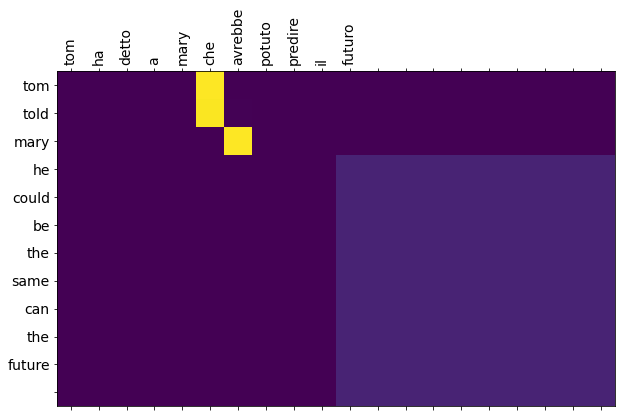

input_sentence era laccordo


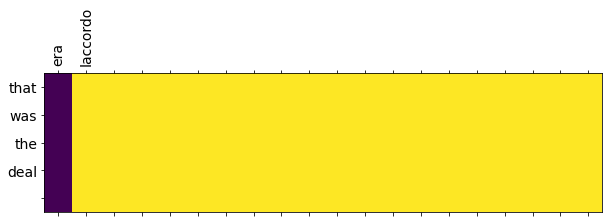

input_sentence dimmi qual è il problema


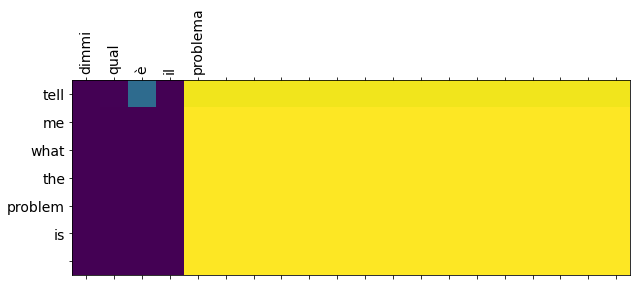

input_sentence tom vuole andare fuori per fare una passeggiata


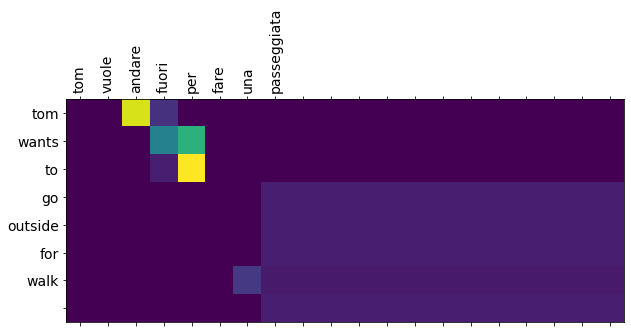

input_sentence tom è stato colpito da una macchina


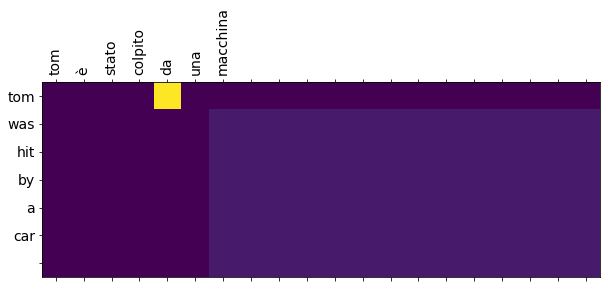

input_sentence tom vuole che aiutiamo mary


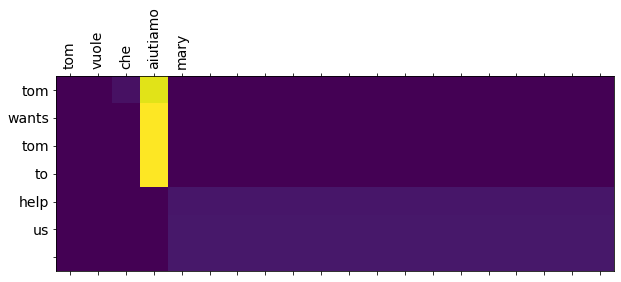

input_sentence feci il buffone


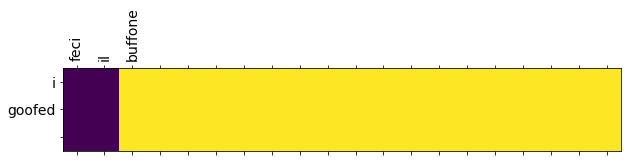

input_sentence il cavallo di tom lha morso


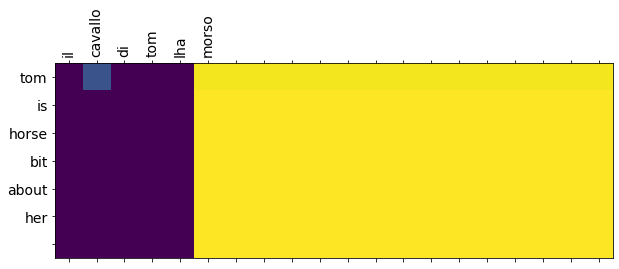

input_sentence questo albergo è stato costruito lanno scorso


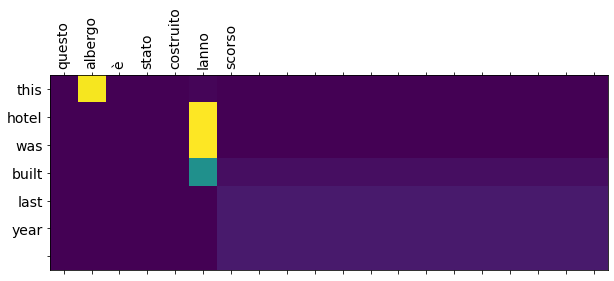

input_sentence chi altro è andato con tom


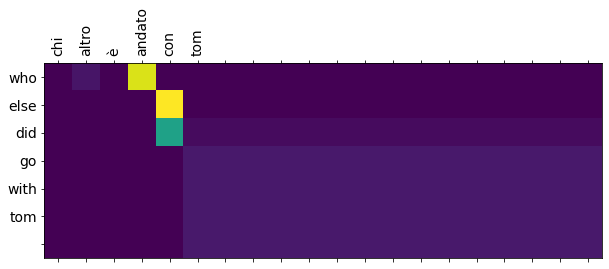

In [ ]:
predicted_sent = []
for input_sentence in prediction_data_inps:
    predicted_sent.append(predict(input_sentence))

In [ ]:
predicted_sent

[['tom',
  'told',
  'mary',
  'he',
  'could',
  'be',
  'the',
  'same',
  'can',
  'the',
  'future'],
 ['that', 'was', 'the', 'deal'],
 ['tell', 'me', 'what', 'the', 'problem', 'is'],
 ['tom', 'wants', 'to', 'go', 'outside', 'for', 'walk'],
 ['tom', 'was', 'hit', 'by', 'a', 'car'],
 ['tom', 'wants', 'tom', 'to', 'help', 'us'],
 ['i', 'goofed'],
 ['tom', 'is', 'horse', 'bit', 'about', 'her'],
 ['this', 'hotel', 'was', 'built', 'last', 'year'],
 ['who', 'else', 'did', 'go', 'with', 'tom']]

<font color='PowderBlue'>**Calculate BLEU score**</font>

In [ ]:
prediction_data = validation.sample(1000)
prediction_data.head()

,italian,english_inp,english_out
222885,non riesco ad andare in palestra stasera,<start> i can not go to the gym tonight,i can not go to the gym tonight <end>
92326,cè un grande pericolo,<start> there is great danger,there is great danger <end>
288577,ero interessata a vedere la città,<start> i was interested in seeing the city,i was interested in seeing the city <end>
108940,tom non è malato vero,<start> tom is not sick is he,tom is not sick is he <end>
90402,era una buona risposta,<start> it was a good answer,it was a good answer <end>


In [ ]:
prediction_data_inps = prediction_data['italian'].values

In [ ]:
predicted_sent = []
for input_sentence in prediction_data_inps:
    predicted_sent.append(predict2(input_sentence))

In [ ]:
predicted_sent[:5]

[['i', 'can', 'not', 'go', 'to', 'the', 'gym', 'tonight'],
 ['there', 'is', 'a', 'great', 'danger'],
 ['i', 'was', 'interested', 'in', 'the', 'city', 'to', 'see'],
 ['tom', 'is', 'not', 'sick', 'is', 'he'],
 ['that', 'was', 'a', 'good', 'answer']]

In [ ]:
prediction_eng_inps = prediction_data['english_inp'].values


In [ ]:
eng_inps = []
for i in prediction_eng_inps:
    sent = []
    for j in i.split():
        if j!= '<start>':
            sent.append(j)
        
    eng_inps.append(sent)

eng_inps[:5]

[['i', 'can', 'not', 'go', 'to', 'the', 'gym', 'tonight'],
 ['there', 'is', 'great', 'danger'],
 ['i', 'was', 'interested', 'in', 'seeing', 'the', 'city'],
 ['tom', 'is', 'not', 'sick', 'is', 'he'],
 ['it', 'was', 'a', 'good', 'answer']]

In [ ]:
import nltk.translate.bleu_score as bleu
blue_score = []
for i in range(len(predicted_sent)):
    blue_score.append(bleu.sentence_bleu([eng_inps[i]], predicted_sent[i]))

In [ ]:
#Average Blue Score
print('avg_blue_score ',(sum(blue_score)/len(blue_score)))

avg_blue_score  0.7911437684506459


# <font color='Red'>**Model-4 Concat Scoring**</font>

In [ ]:
class Encoder_Decoder(tf.keras.Model):
  def __init__(self,encoder_inputs_length,decoder_inputs_length, output_vocab_size):
    #Intialize objects from encoder decoder
    super().__init__() 
    #create encoder object
    self.encoder = Encoder(inp_vocab_size=vocab_size_ita+1, embedding_size=200, input_length=encoder_inputs_length, lstm_size=256)
    #create decoder object
    self.decoder = Decoder(out_vocab_size=vocab_size_eng+1, embedding_dim=200, input_length=decoder_inputs_length,dec_units = 256,score_fun = 'concat',att_units=256)

  
  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    input,output = data[0], data[1]
    batch_size = 1024
    states                               = self.encoder.initialize_states(batch_size)
    encoder_output, encoder_h, encoder_c = self.encoder(input,states)
    encoder_states                       = [encoder_h, encoder_c]
    decoder_hidden_state                 = encoder_h
    decoder_cell_state                   = encoder_c
    decoder_output                       = self.decoder(output, encoder_output,decoder_hidden_state,decoder_cell_state)
    return decoder_output

In [ ]:
checkpoint_path = "Attention_concat_model/w1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
%%time
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model
model = Encoder_Decoder(encoder_inputs_length=20,decoder_inputs_length=20,output_vocab_size=vocab_size_eng)
model.compile(optimizer=optimizer,loss=custom_lossfunction)
train_steps=train.shape[0]//1024
valid_steps=validation.shape[0]//1024
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs=30, validation_data=test_dataloader, validation_steps=valid_steps,callbacks=[cp_callback])
model.summary()

Epoch 1/30
268/268 [==============================] - 186s 607ms/step - loss: 1.9028 - val_loss: 1.5129

Epoch 00001: saving model to Attention_concat_model/w1.ckpt
Epoch 2/30
268/268 [==============================] - 158s 590ms/step - loss: 1.4688 - val_loss: 1.3365

Epoch 00002: saving model to Attention_concat_model/w1.ckpt
Epoch 3/30
268/268 [==============================] - 159s 592ms/step - loss: 1.2984 - val_loss: 1.1972

Epoch 00003: saving model to Attention_concat_model/w1.ckpt
Epoch 4/30
268/268 [==============================] - 158s 588ms/step - loss: 1.1557 - val_loss: 1.0660

Epoch 00004: saving model to Attention_concat_model/w1.ckpt
Epoch 5/30
268/268 [==============================] - 158s 590ms/step - loss: 1.0232 - val_loss: 0.9511

Epoch 00005: saving model to Attention_concat_model/w1.ckpt
Epoch 6/30
268/268 [==============================] - 158s 589ms/step - loss: 0.9027 - val_loss: 0.8520

Epoch 00006: saving model to Attention_concat_model/w1.ckpt
Epoch 7/30

In [ ]:
prediction_data = validation.sample(10)
prediction_data.head()

,italian,english_inp,english_out
184829,tom lha fissata con un martello,<start> tom fixed it with a hammer,tom fixed it with a hammer <end>
249537,non avevo amici fatta eccezione per tom,<start> i had no friends except for tom,i had no friends except for tom <end>
22558,tom stava scherzando,<start> was tom joking,was tom joking <end>
330439,voi sapevate che tom e john erano i fratelli d...,<start> did you know tom and john were mary is...,did you know tom and john were mary is brother...
184621,tom non voleva essere qui,<start> tom did not want to be here,tom did not want to be here <end>


In [ ]:
prediction_data_inps = prediction_data['italian'].values

input_sentence tom lha fissata con un martello


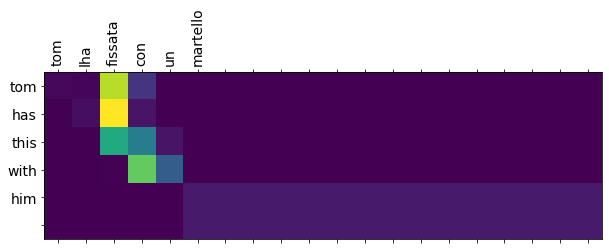

input_sentence non avevo amici fatta eccezione per tom


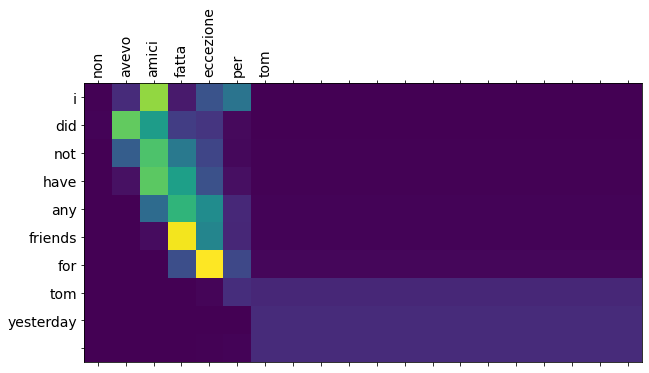

input_sentence tom stava scherzando


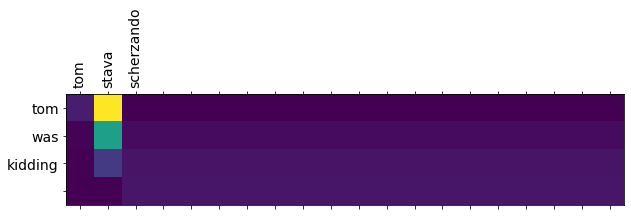

input_sentence voi sapevate che tom e john erano i fratelli di mary


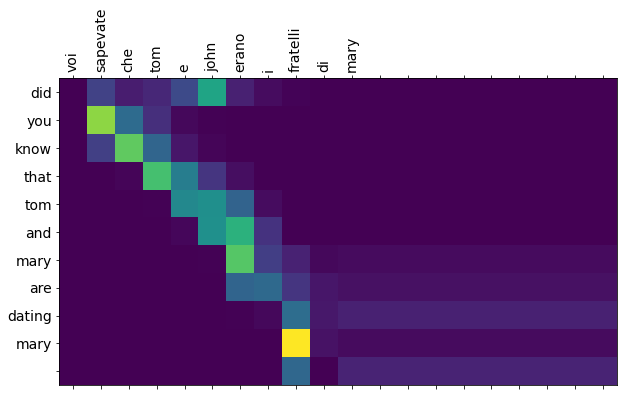

input_sentence tom non voleva essere qui


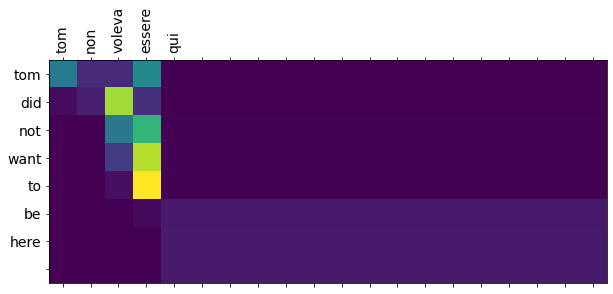

input_sentence perché sei sempre così meschino


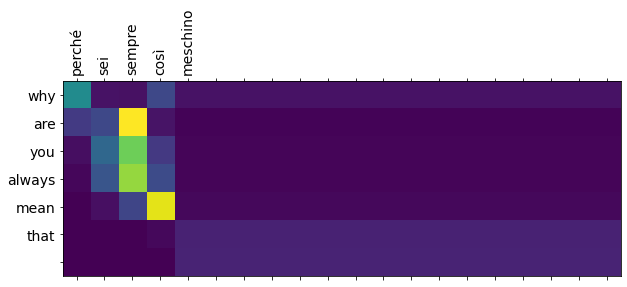

input_sentence non ribadire lovvio


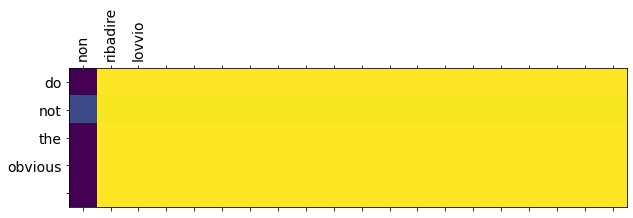

input_sentence io non ho mai detto questo a nessuno prima


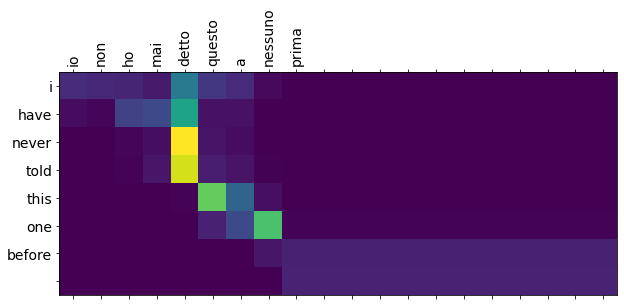

input_sentence sono state arrestate molte persone


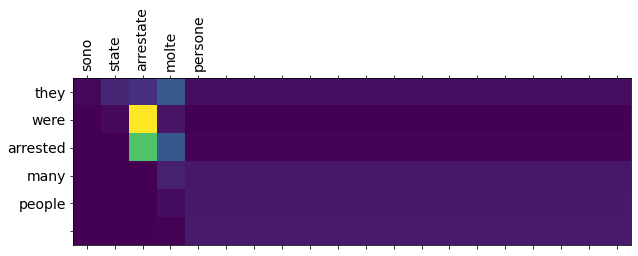

input_sentence sei felice


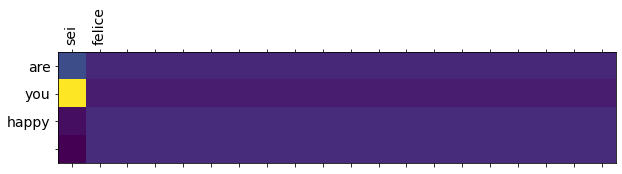

In [ ]:
predicted_sent = []
for input_sentence in prediction_data_inps:
    predicted_sent.append(predict(input_sentence))

In [ ]:
predicted_sent

[['tom', 'has', 'this', 'with', 'him'],
 ['i', 'did', 'not', 'have', 'any', 'friends', 'for', 'tom', 'yesterday'],
 ['tom', 'was', 'kidding'],
 ['did', 'you', 'know', 'that', 'tom', 'and', 'mary', 'are', 'dating', 'mary'],
 ['tom', 'did', 'not', 'want', 'to', 'be', 'here'],
 ['why', 'are', 'you', 'always', 'mean', 'that'],
 ['do', 'not', 'the', 'obvious'],
 ['i', 'have', 'never', 'told', 'this', 'one', 'before'],
 ['they', 'were', 'arrested', 'many', 'people'],
 ['are', 'you', 'happy']]

<font color='PowderBlue'>**Calculate BLEU score**</font>

In [ ]:
prediction_data = validation.sample(1000)
prediction_data.head()

,italian,english_inp,english_out
109008,tom sa cucinare,<start> tom knows how to cook,tom knows how to cook <end>
309684,bisognerebbe dormire otto ore al giorno,<start> you should sleep for eight hours a day,you should sleep for eight hours a day <end>
6845,cosera,<start> what was it,what was it <end>
255184,tom promise di ripararlo per me,<start> tom promised to fix that for me,tom promised to fix that for me <end>
176968,sarà sempre con lei,<start> he will always be with you,he will always be with you <end>


In [ ]:
prediction_data_inps = prediction_data['italian'].values

In [ ]:
predicted_sent = []
for input_sentence in prediction_data_inps:
    predicted_sent.append(predict2(input_sentence))

In [ ]:
predicted_sent[:5]

[['tom', 'knows', 'how', 'to', 'cook'],
 ['you', 'should', 'sleep', 'eight', 'hours', 'left'],
 ['what', 'was', 'it'],
 ['tom', 'promised', 'to', 'fix', 'that', 'for', 'me'],
 ['he', 'will', 'always', 'be', 'with', 'you']]

In [ ]:
prediction_eng_inps = prediction_data['english_inp'].values


In [ ]:

eng_inps = []
for i in prediction_eng_inps:
    sent = []
    for j in i.split():
        if j!= '<start>':
            sent.append(j)
            
    eng_inps.append(sent)

eng_inps[:5]

[['tom', 'knows', 'how', 'to', 'cook'],
 ['you', 'should', 'sleep', 'for', 'eight', 'hours', 'a', 'day'],
 ['what', 'was', 'it'],
 ['tom', 'promised', 'to', 'fix', 'that', 'for', 'me'],
 ['he', 'will', 'always', 'be', 'with', 'you']]

In [ ]:
import nltk.translate.bleu_score as bleu
blue_score = []
for i in range(len(predicted_sent)):
    blue_score.append(bleu.sentence_bleu([eng_inps[i]], predicted_sent[i]))

In [ ]:
blue_score[:5]

[1.0, 0.4260520663282873, 1.0, 1.0, 1.0]

In [ ]:
#Average Blue Score
print('avg_blue_score ',(sum(blue_score)/len(blue_score)))

avg_blue_score  0.7829940126087284


<font size = 5 color = 'Aquamarine' > Observations: - </font>

1. For Concat scoring attention weights are more clearer in telling that which word helps in predicting which word in comparison to other two scoring techniques.
2. Although from Blue Score performance of each scoring technique is almost similar. .
3. By Writing code for different scoring I better able to understand about how attention mechanism works and context vector is calculated.
4. Impact of using attention is clearly visible if we look at the blue score value.
5. Even though we have small number datapoints still attention mechanism worked pretty well.
6. I observed that longer sentence are not predicted very well by either of the encoder decoder mechanism.
7. For small sentences not only the words but also the order of words is correct well for most.
8. If we could train the model on larger dataset and with more intricate embedding vectors result could be far better.

